1. Import necessary packages

In [9]:
import numpy as np
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

import seaborn as sns
import torch.nn.functional as F

2. Set random seed for reproducibility

In [10]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # disables optimizations for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

3. Load the train data

In [11]:
# Load the combined_labels.npy file
mytool = "electric_screwdriver" # pneumatic_screwdriver,electric_screwdriver
output_dir = "./processed_data/"

# Load the saved NumPy arrays
combined_data = np.load(os.path.join(output_dir, f"combined_data_train_{mytool}.npy"))
combined_labels = np.load(os.path.join(output_dir, f"combined_label_train_{mytool}.npy"))

4. Perform training with k fold validation


--- Fold 1 ---
Epoch 1: Train Acc = 0.4562, Val Acc = 0.4571
Epoch 2: Train Acc = 0.5000, Val Acc = 0.4643
Epoch 3: Train Acc = 0.5563, Val Acc = 0.6250
Epoch 4: Train Acc = 0.6464, Val Acc = 0.5464
Epoch 5: Train Acc = 0.5893, Val Acc = 0.6429
Epoch 6: Train Acc = 0.7625, Val Acc = 0.8250
Epoch 7: Train Acc = 0.8357, Val Acc = 0.8500
Epoch 8: Train Acc = 0.8670, Val Acc = 0.8750
Epoch 9: Train Acc = 0.8652, Val Acc = 0.8643
Epoch 10: Train Acc = 0.8723, Val Acc = 0.9214
Epoch 11: Train Acc = 0.8991, Val Acc = 0.8821
Epoch 12: Train Acc = 0.9080, Val Acc = 0.9143
Epoch 13: Train Acc = 0.9054, Val Acc = 0.9143
Epoch 14: Train Acc = 0.9062, Val Acc = 0.9214
Epoch 15: Train Acc = 0.9214, Val Acc = 0.9179
Epoch 16: Train Acc = 0.9277, Val Acc = 0.9286
Epoch 17: Train Acc = 0.9259, Val Acc = 0.9179
Epoch 18: Train Acc = 0.9259, Val Acc = 0.9143
Epoch 19: Train Acc = 0.9429, Val Acc = 0.9286
Epoch 20: Train Acc = 0.9357, Val Acc = 0.9286
Epoch 21: Train Acc = 0.9304, Val Acc = 0.9179
Epoch 

c:\Users\vinee\anaconda3\envs\tool-tracking_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vinee\anaconda3\envs\tool-tracking_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vinee\anaconda3\envs\tool-tracking_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

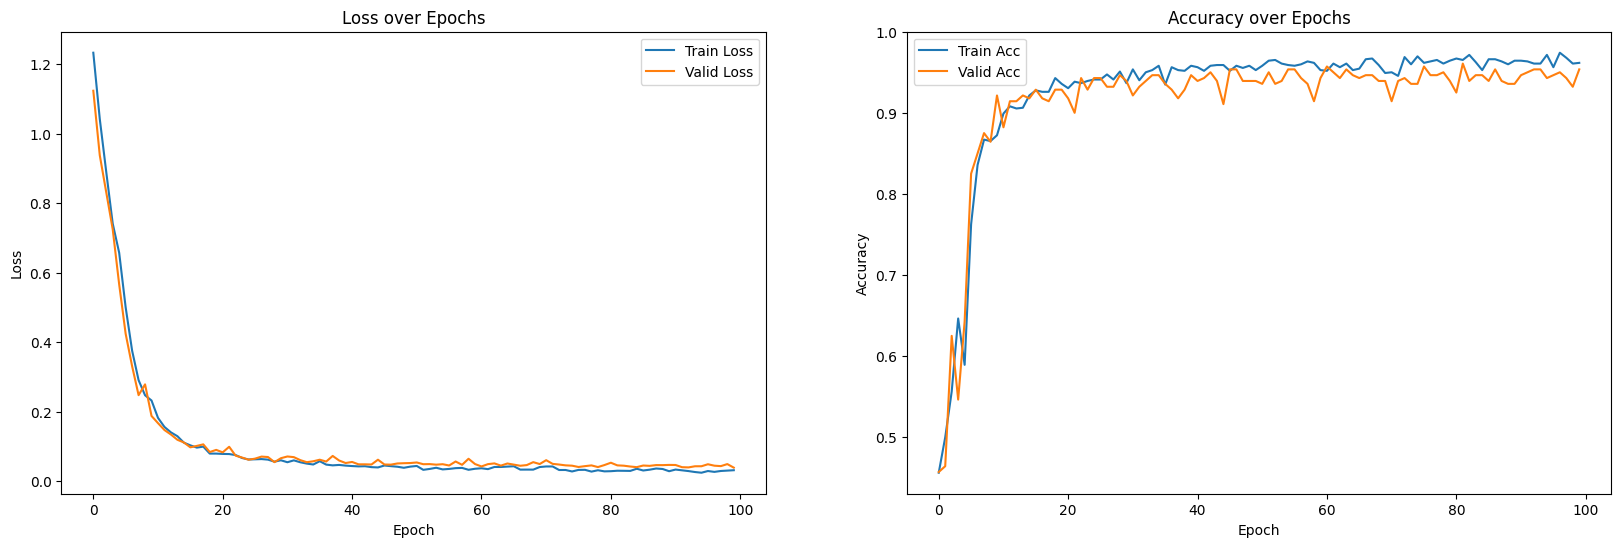

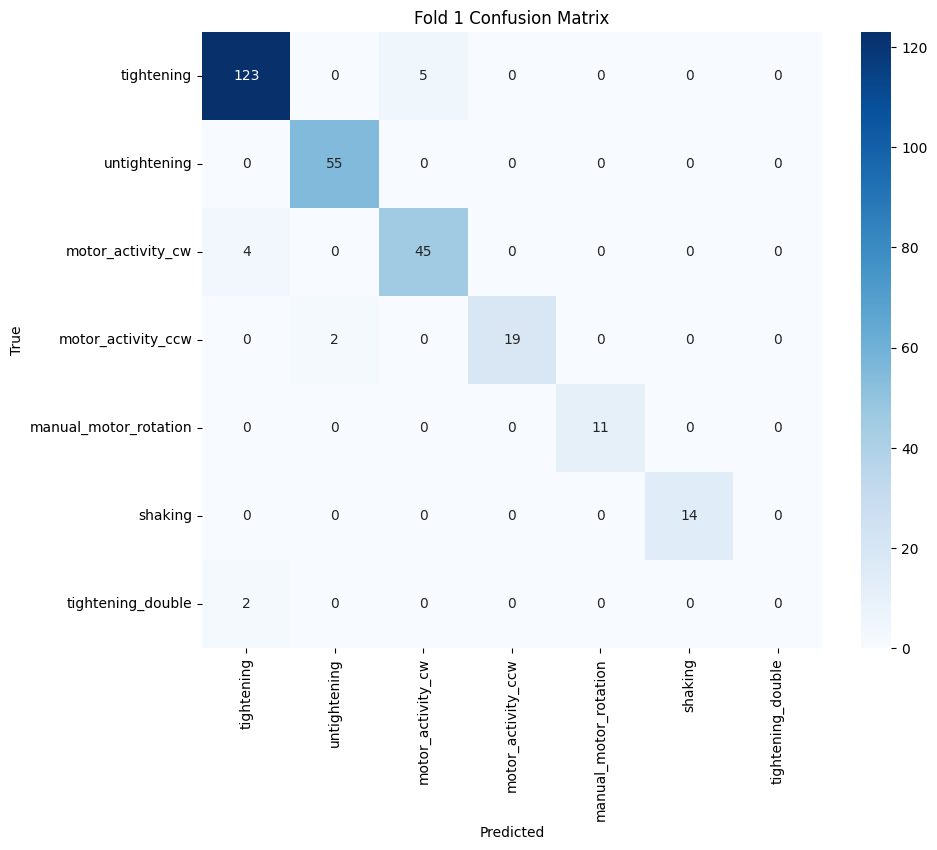


--- Fold 2 ---
Epoch 1: Train Acc = 0.3679, Val Acc = 0.4607
Epoch 2: Train Acc = 0.4598, Val Acc = 0.4607
Epoch 3: Train Acc = 0.5205, Val Acc = 0.5750
Epoch 4: Train Acc = 0.6723, Val Acc = 0.7536
Epoch 5: Train Acc = 0.7580, Val Acc = 0.8071
Epoch 6: Train Acc = 0.8116, Val Acc = 0.8536
Epoch 7: Train Acc = 0.8313, Val Acc = 0.8679
Epoch 8: Train Acc = 0.8402, Val Acc = 0.8643
Epoch 9: Train Acc = 0.8482, Val Acc = 0.8929
Epoch 10: Train Acc = 0.8795, Val Acc = 0.8929
Epoch 11: Train Acc = 0.9071, Val Acc = 0.9071
Epoch 12: Train Acc = 0.9071, Val Acc = 0.9071
Epoch 13: Train Acc = 0.8929, Val Acc = 0.9107
Epoch 14: Train Acc = 0.9018, Val Acc = 0.9179
Epoch 15: Train Acc = 0.9116, Val Acc = 0.9107
Epoch 16: Train Acc = 0.9125, Val Acc = 0.9000
Epoch 17: Train Acc = 0.9062, Val Acc = 0.9286
Epoch 18: Train Acc = 0.9250, Val Acc = 0.9321
Epoch 19: Train Acc = 0.9161, Val Acc = 0.9107
Epoch 20: Train Acc = 0.9286, Val Acc = 0.9321
Epoch 21: Train Acc = 0.9357, Val Acc = 0.9321
Epoch 

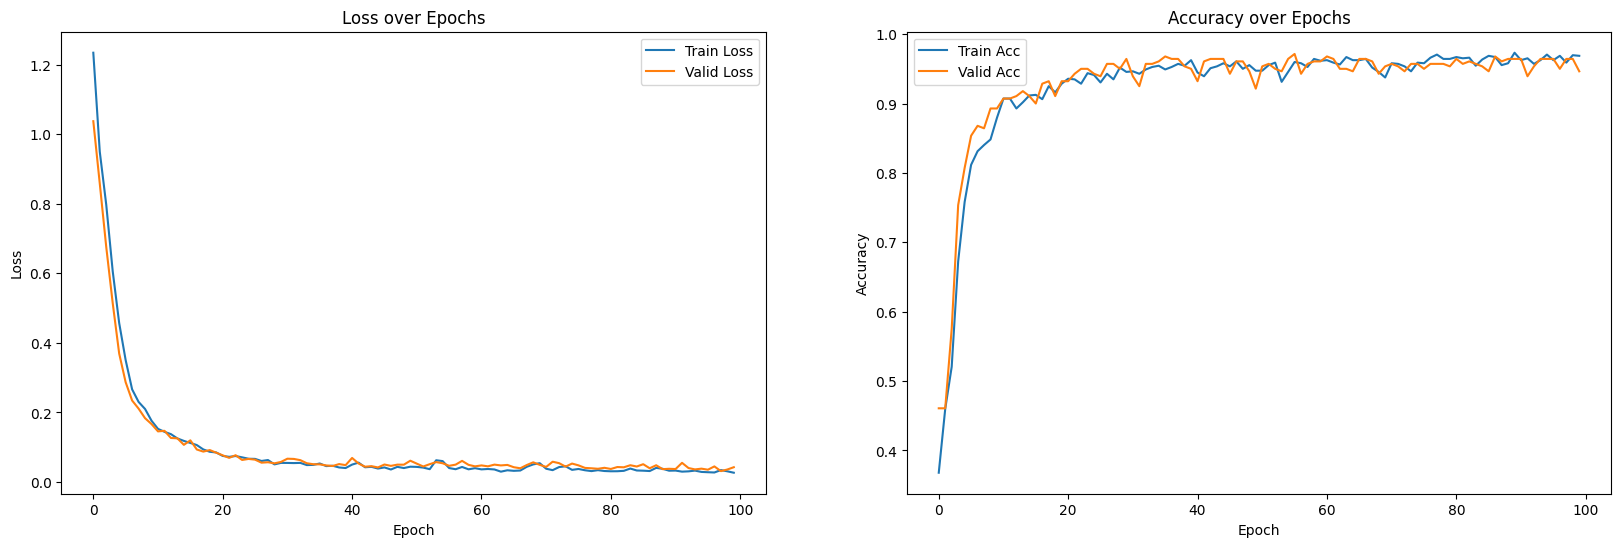

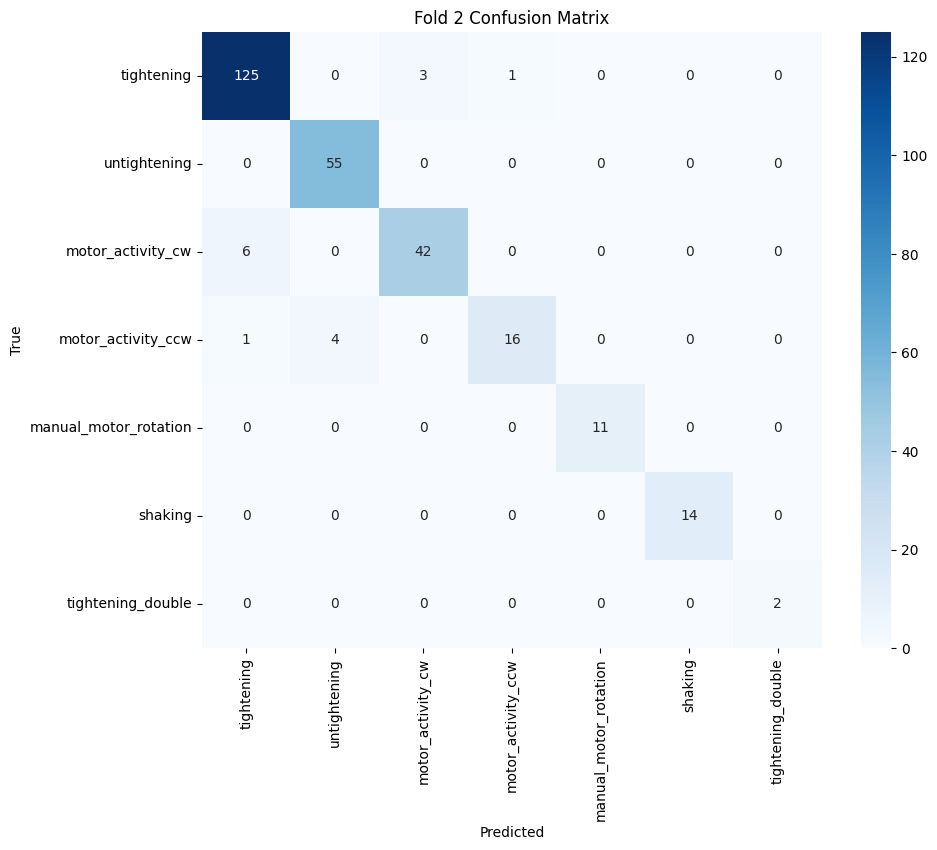


--- Fold 3 ---
Epoch 1: Train Acc = 0.2741, Val Acc = 0.4857
Epoch 2: Train Acc = 0.5045, Val Acc = 0.4607
Epoch 3: Train Acc = 0.4839, Val Acc = 0.5036
Epoch 4: Train Acc = 0.6188, Val Acc = 0.6929
Epoch 5: Train Acc = 0.7339, Val Acc = 0.7893
Epoch 6: Train Acc = 0.7911, Val Acc = 0.7893
Epoch 7: Train Acc = 0.8089, Val Acc = 0.8036
Epoch 8: Train Acc = 0.8446, Val Acc = 0.8643
Epoch 9: Train Acc = 0.8589, Val Acc = 0.8536
Epoch 10: Train Acc = 0.8750, Val Acc = 0.8643
Epoch 11: Train Acc = 0.8830, Val Acc = 0.8964
Epoch 12: Train Acc = 0.8938, Val Acc = 0.9000
Epoch 13: Train Acc = 0.8938, Val Acc = 0.8857
Epoch 14: Train Acc = 0.8884, Val Acc = 0.8821
Epoch 15: Train Acc = 0.8982, Val Acc = 0.9036
Epoch 16: Train Acc = 0.9080, Val Acc = 0.8714
Epoch 17: Train Acc = 0.9045, Val Acc = 0.8964
Epoch 18: Train Acc = 0.9214, Val Acc = 0.9143
Epoch 19: Train Acc = 0.9179, Val Acc = 0.8964
Epoch 20: Train Acc = 0.9187, Val Acc = 0.9000
Epoch 21: Train Acc = 0.9232, Val Acc = 0.9036
Epoch 

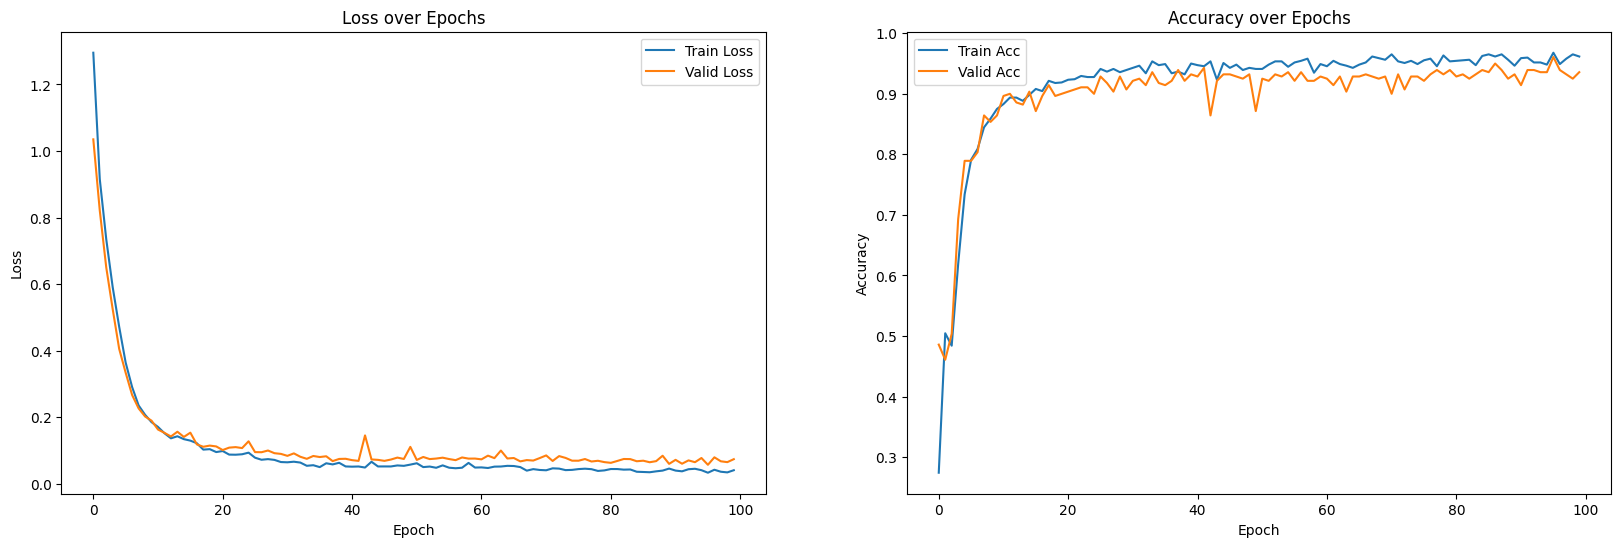

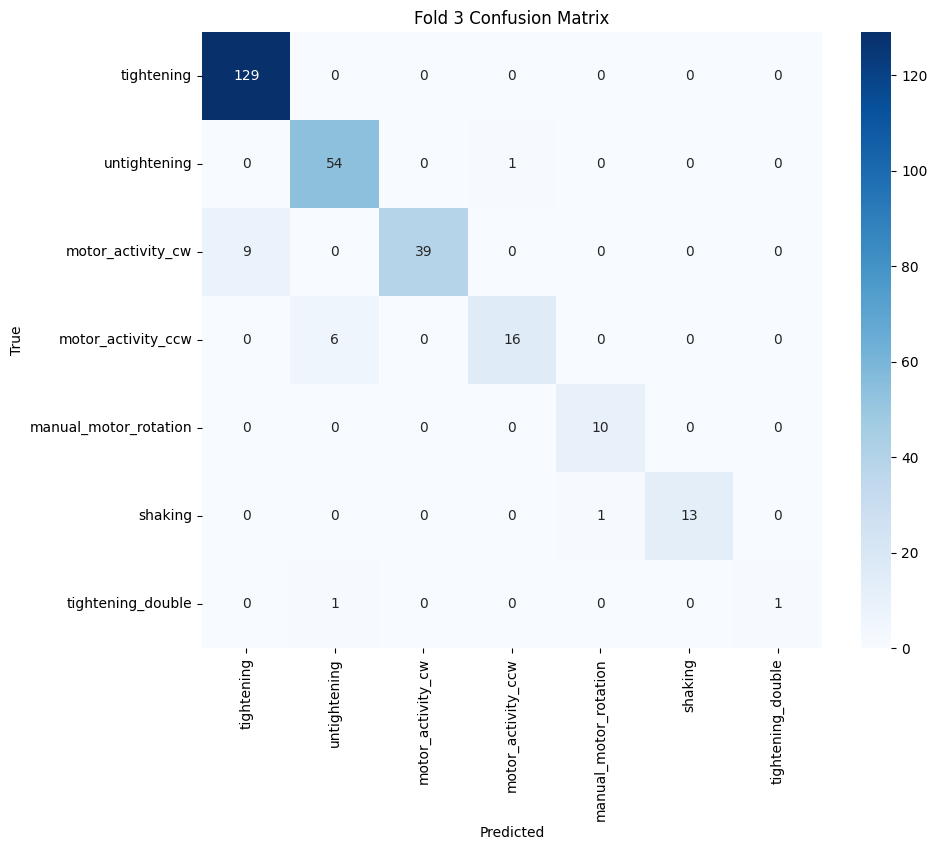


--- Fold 4 ---
Epoch 1: Train Acc = 0.0946, Val Acc = 0.4643
Epoch 2: Train Acc = 0.4571, Val Acc = 0.4643
Epoch 3: Train Acc = 0.4804, Val Acc = 0.4893
Epoch 4: Train Acc = 0.5071, Val Acc = 0.5429
Epoch 5: Train Acc = 0.6616, Val Acc = 0.7000
Epoch 6: Train Acc = 0.7473, Val Acc = 0.7429
Epoch 7: Train Acc = 0.8179, Val Acc = 0.8321
Epoch 8: Train Acc = 0.8384, Val Acc = 0.8286
Epoch 9: Train Acc = 0.8500, Val Acc = 0.8393
Epoch 10: Train Acc = 0.8661, Val Acc = 0.8536
Epoch 11: Train Acc = 0.8821, Val Acc = 0.8821
Epoch 12: Train Acc = 0.8982, Val Acc = 0.9036
Epoch 13: Train Acc = 0.9027, Val Acc = 0.9000
Epoch 14: Train Acc = 0.9205, Val Acc = 0.9036
Epoch 15: Train Acc = 0.9018, Val Acc = 0.9107
Epoch 16: Train Acc = 0.9045, Val Acc = 0.9107
Epoch 17: Train Acc = 0.9214, Val Acc = 0.9143
Epoch 18: Train Acc = 0.9205, Val Acc = 0.9143
Epoch 19: Train Acc = 0.9277, Val Acc = 0.9000
Epoch 20: Train Acc = 0.9366, Val Acc = 0.9000
Epoch 21: Train Acc = 0.9313, Val Acc = 0.9214
Epoch 

c:\Users\vinee\anaconda3\envs\tool-tracking_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vinee\anaconda3\envs\tool-tracking_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vinee\anaconda3\envs\tool-tracking_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

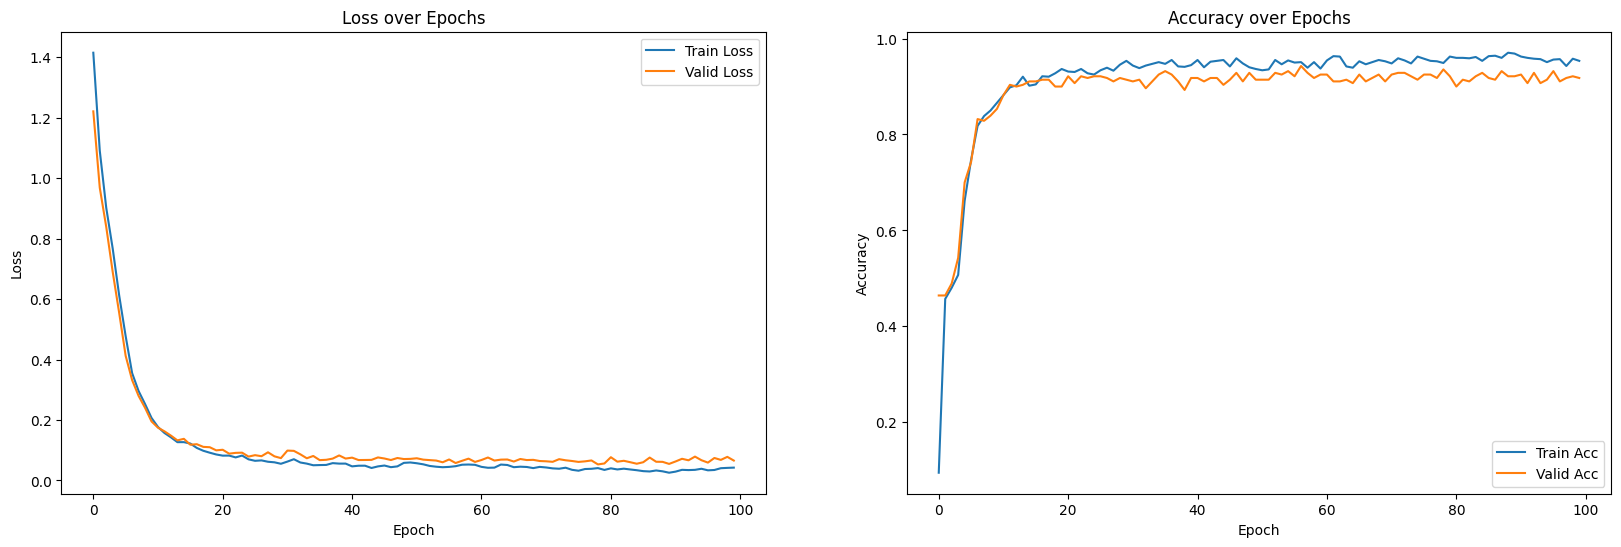

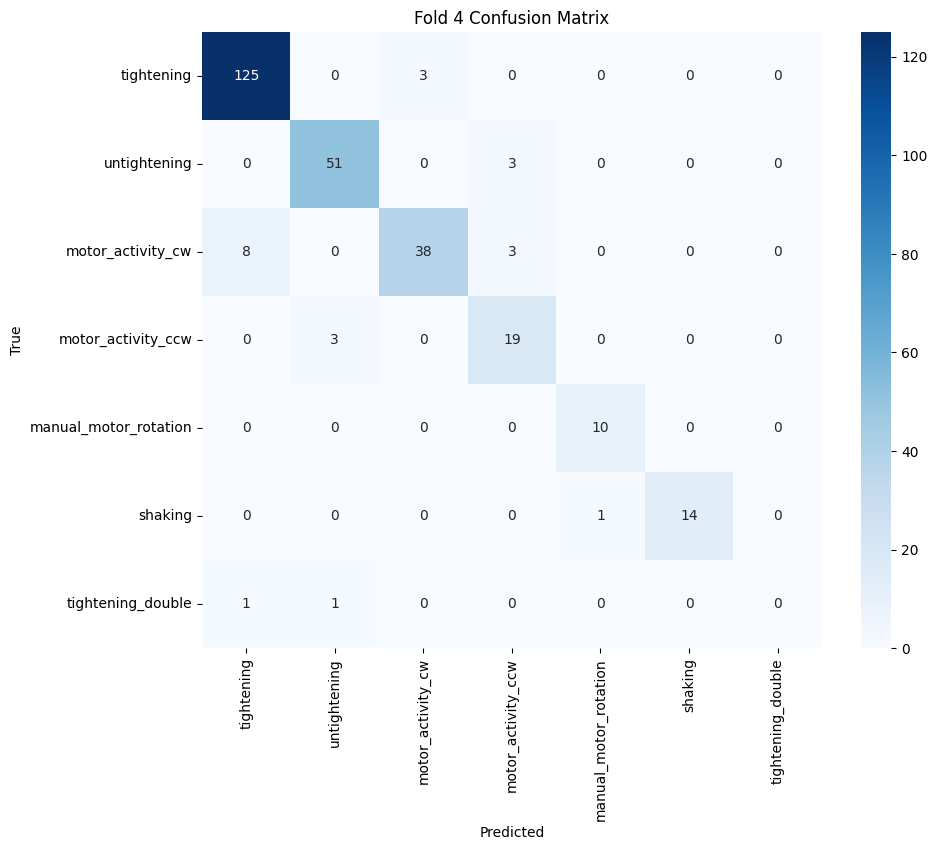


--- Fold 5 ---
Epoch 1: Train Acc = 0.3804, Val Acc = 0.4571
Epoch 2: Train Acc = 0.4580, Val Acc = 0.4571
Epoch 3: Train Acc = 0.4902, Val Acc = 0.5000
Epoch 4: Train Acc = 0.6098, Val Acc = 0.6571
Epoch 5: Train Acc = 0.7393, Val Acc = 0.7786
Epoch 6: Train Acc = 0.8009, Val Acc = 0.7929
Epoch 7: Train Acc = 0.8223, Val Acc = 0.8250
Epoch 8: Train Acc = 0.8420, Val Acc = 0.8429
Epoch 9: Train Acc = 0.8643, Val Acc = 0.8500
Epoch 10: Train Acc = 0.8696, Val Acc = 0.8750
Epoch 11: Train Acc = 0.8911, Val Acc = 0.8429
Epoch 12: Train Acc = 0.9009, Val Acc = 0.8643
Epoch 13: Train Acc = 0.9098, Val Acc = 0.8464
Epoch 14: Train Acc = 0.8848, Val Acc = 0.8714
Epoch 15: Train Acc = 0.8973, Val Acc = 0.8786
Epoch 16: Train Acc = 0.9062, Val Acc = 0.8750
Epoch 17: Train Acc = 0.9205, Val Acc = 0.8857
Epoch 18: Train Acc = 0.9062, Val Acc = 0.8643
Epoch 19: Train Acc = 0.9054, Val Acc = 0.8821
Epoch 20: Train Acc = 0.9054, Val Acc = 0.8929
Epoch 21: Train Acc = 0.9295, Val Acc = 0.9036
Epoch 

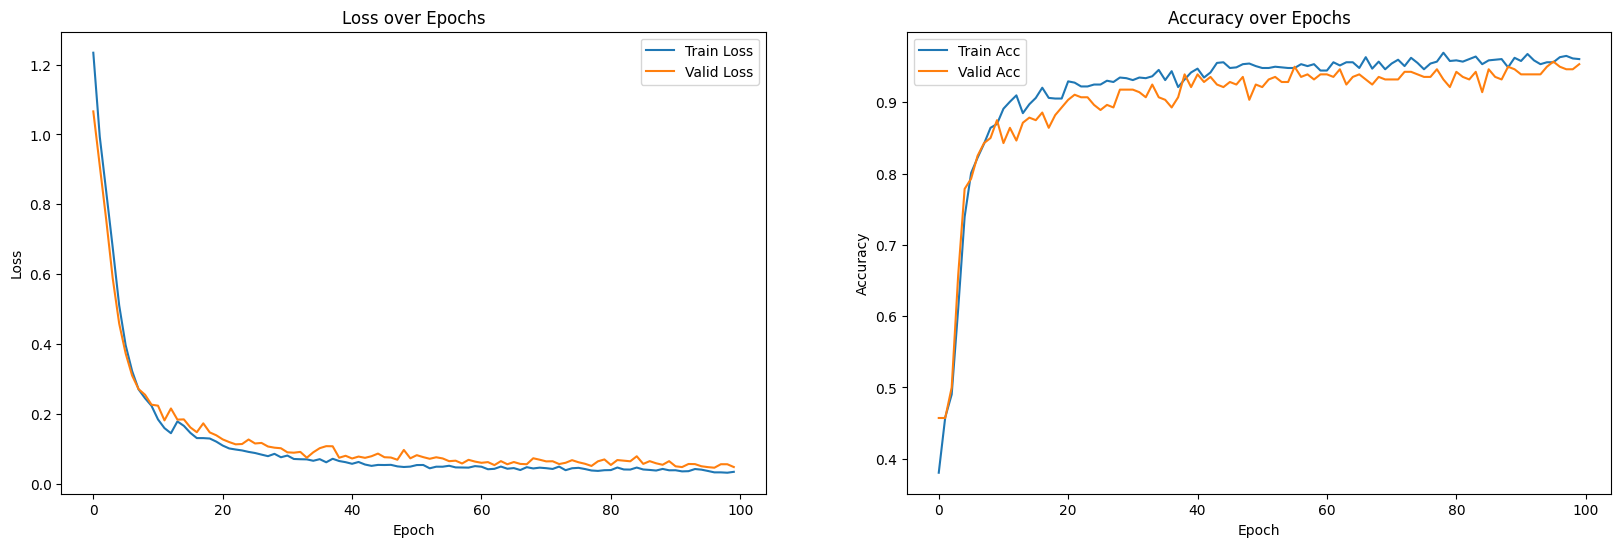

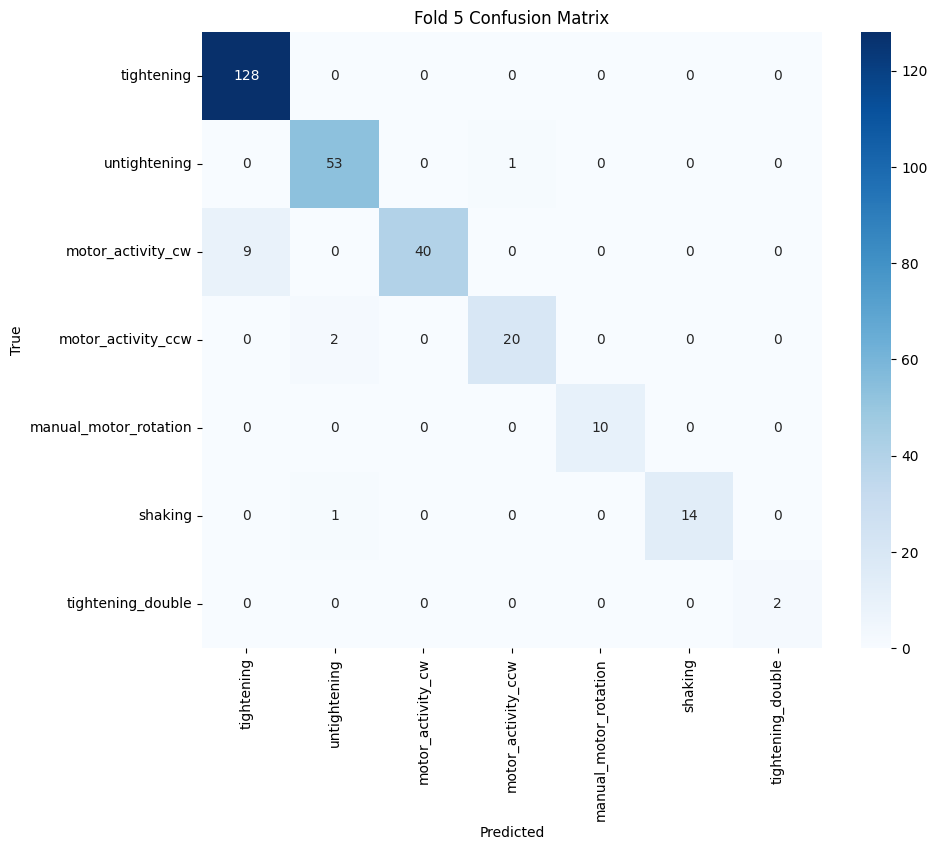


Average Accuracy over 5 folds: 0.9414
Average Weighted F1 Score over 5 folds: 0.9389


In [12]:
if mytool == "electric_screwdriver":
    label_info = {
        2: 'tightening',
        3: 'untightening',
        4: 'motor_activity_cw',
        5: 'motor_activity_ccw',
        6: 'manual_motor_rotation',
        7: 'shaking',
        14: 'tightening_double'
    }
elif mytool == "pneumatic_screwdriver":
    label_info = {
        2: 'tightening',
        3: 'untightening',
        4: 'motor_activity_cw',
        5: 'motor_activity_ccw',
        7: 'shaking',
        14: 'tightening_double',
        38: 'impact'
    }

valid_labels = list(label_info.keys())

# Training data and labels
X = combined_data
y = combined_labels

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y_encoded)



# ---------------- Model and Loss ---------------- #
class EnhancedToolLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.1):
        super(EnhancedToolLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        out = self.dropout(last_out)
        return self.fc(out)

class SimpleFocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super(SimpleFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = torch.tensor(alpha, dtype=torch.float32) if alpha is not None else None

    def forward(self, inputs, targets):
        device = inputs.device
        log_probs = F.log_softmax(inputs, dim=1)
        probs = log_probs.exp()
        log_probs_true = log_probs.gather(1, targets.view(-1, 1)).squeeze(1)
        probs_true = probs.gather(1, targets.view(-1, 1)).squeeze(1).clamp(min=1e-9)
        if self.alpha is not None:
            alpha_t = self.alpha.to(device)[targets]
            loss = -alpha_t * (1 - probs_true)**self.gamma * log_probs_true
        else:
            loss = - (1 - probs_true)**self.gamma * log_probs_true
        return loss.mean()

# ---------------- K-Fold Training Loop ---------------- #
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X.shape[2]
output_dim = len(label_info)
hidden_dim = 64
batch_size = 32
num_epochs = 200 if mytool == "pneumatic_screwdriver" else 100

fold_accuracies, fold_f1s = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_tensor, y_tensor)):
    print(f"\n--- Fold {fold+1} ---")

    X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
    y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]

    # --- Weighted Sampling for class imbalance ---
    class_sample_counts = np.array([(y_train == t).sum() for t in torch.unique(y_train)])
    weights = 1. / class_sample_counts
    samples_weight = np.array([weights[t] for t in y_train.numpy()])
    samples_weight = torch.from_numpy(samples_weight).float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size,shuffle= True)
    if mytool == "pneumatic_screwdriver":
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

    model = EnhancedToolLSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(device)
    criterion = SimpleFocalLoss(gamma=2.0)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        model.eval()
        valid_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        valid_losses.append(valid_loss / len(val_loader))
        valid_accuracies.append(correct / total)
        print(f"Epoch {epoch+1}: Train Acc = {train_accuracies[-1]:.4f}, Val Acc = {valid_accuracies[-1]:.4f}")

    # Final Evaluation on Validation Set
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    fold_accuracies.append(acc)
    fold_f1s.append(f1)

    # Training Curves
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.legend()
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(valid_accuracies, label='Valid Acc')
    plt.legend()
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    print(f"\nFold {fold+1} Accuracy: {acc:.4f}")
    print(f"Fold {fold+1} Weighted F1 Score: {f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=[label_info[i] for i in valid_labels]))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_info.values(), yticklabels=label_info.values())
    plt.title(f'Fold {fold+1} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# ---------------- Overall Summary ---------------- #
print(f"\nAverage Accuracy over {n_splits} folds: {np.mean(fold_accuracies):.4f}")
print(f"Average Weighted F1 Score over {n_splits} folds: {np.mean(fold_f1s):.4f}")


5. Save the trained model

In [13]:
# Define directory for saving
model_dir = "./trained_model/"
os.makedirs(model_dir, exist_ok=True)

# File path to save the weights
model_file = os.path.join(model_dir, f"enhanced_lstm_model_{mytool}.pth")

# Save the state dictionary
torch.save(model.state_dict(), model_file)

print(f"Model successfully saved to {model_file}.")


Model successfully saved to ./trained_model/enhanced_lstm_model_electric_screwdriver.pth.


6. Load the model for testing

In [14]:
# Reload the model with the SAME architecture first
num_of_classes = len(label_info)
loaded_model = EnhancedToolLSTM(input_dim=X.shape[2],
                           hidden_dim=64,
                           output_dim=num_of_classes)
loaded_model.to(device)

# File path for the trained weights
model_file = os.path.join(model_dir, f"enhanced_lstm_model_{mytool}.pth")

# Loading weights into the new instance
loaded_model.load_state_dict(torch.load(model_file, map_location=device))
loaded_model.eval()

print("Model successfully loaded.")


Model successfully loaded.


7. Evaluate the model on test data

In [15]:
# Load the combined_labels.npy file
output_dir = "./processed_data/"

# Load the saved NumPy arrays
combined_data_test = np.load(os.path.join(output_dir, f"combined_data_test_{mytool}.npy"))
combined_labels_test = np.load(os.path.join(output_dir, f"combined_label_test_{mytool}.npy"))

# Label mapping
if mytool == "electric_screwdriver":
    label_info = {
        2: 'tightening',
        3: 'untightening',
        4: 'motor_activity_cw',
        5: 'motor_activity_ccw',
        6: 'manual_motor_rotation',
        7: 'shaking',
        14: 'tightening_double'
    }
elif mytool == "pneumatic_screwdriver":
    label_info = {
        2: 'tightening',
        3: 'untightening',
        4: 'motor_activity_cw',
        5: 'motor_activity_ccw',
        7: 'shaking',
        14: 'tightening_double',
        38: 'impact'
    }

valid_labels = list(label_info.keys())

X = combined_data_test
y = combined_labels_test

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y) # can be removed as our code uses binary labels directly

# Convert to tensors
X_tensor_test = torch.FloatTensor(X)
y_tensor_test = torch.LongTensor(y_encoded)


Final Accuracy: 0.9314
Final Weighted F1 Score: 0.9306


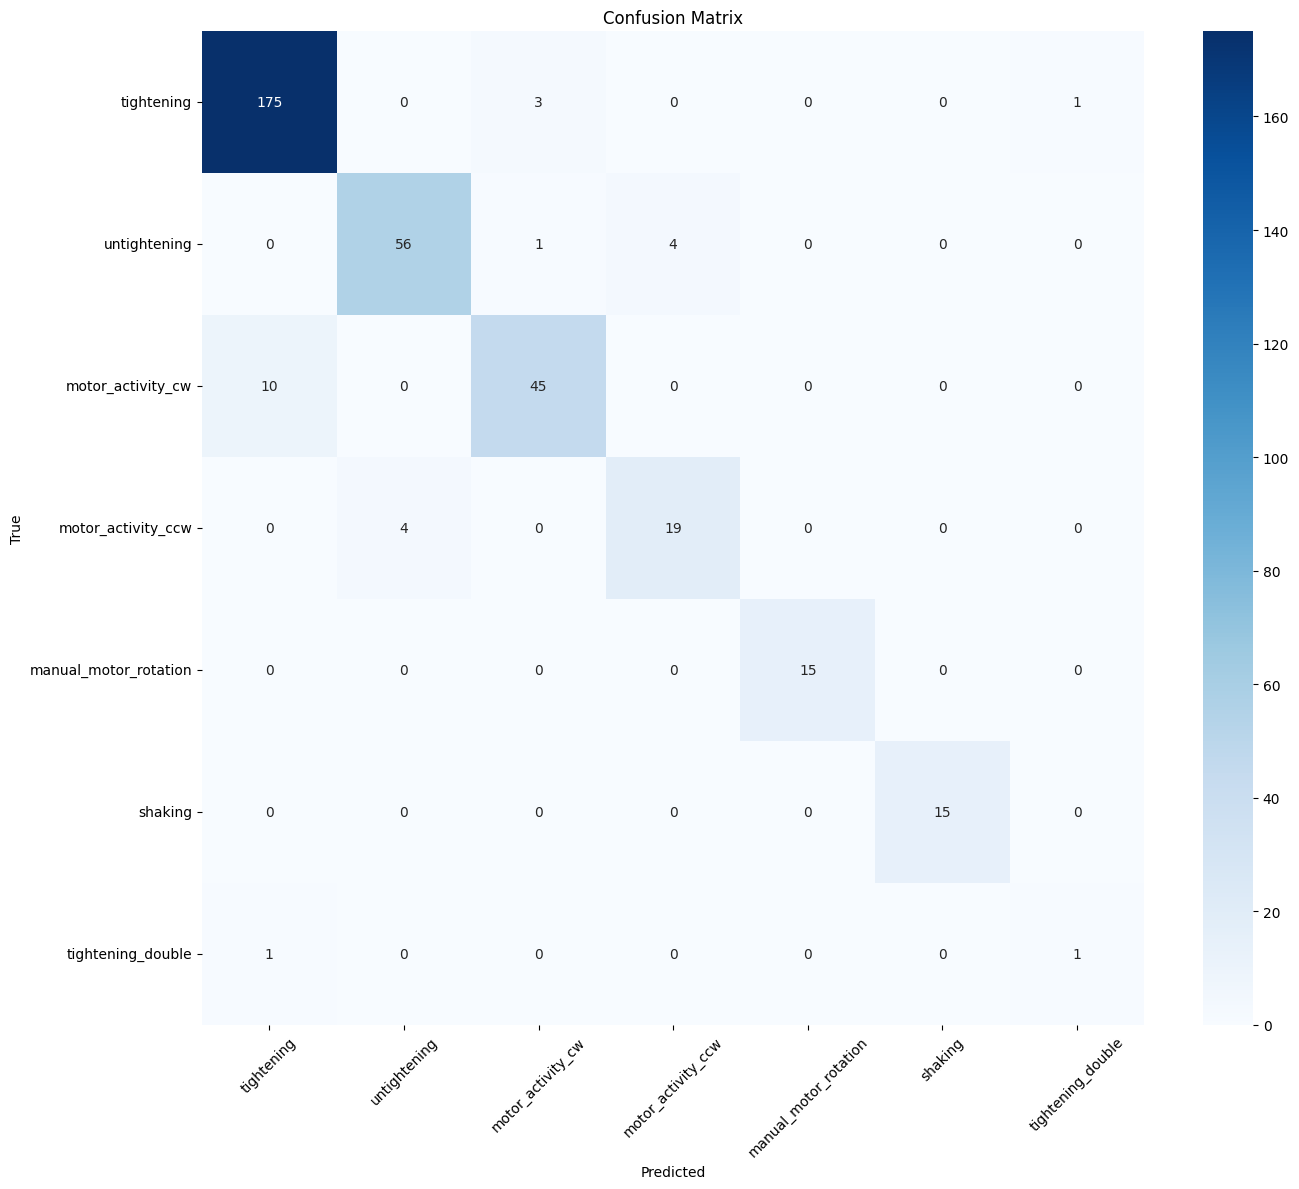


Classification Report:
                       precision    recall  f1-score   support

           tightening       0.94      0.98      0.96       179
         untightening       0.93      0.92      0.93        61
    motor_activity_cw       0.92      0.82      0.87        55
   motor_activity_ccw       0.83      0.83      0.83        23
manual_motor_rotation       1.00      1.00      1.00        15
              shaking       1.00      1.00      1.00        15
    tightening_double       0.50      0.50      0.50         2

             accuracy                           0.93       350
            macro avg       0.87      0.86      0.87       350
         weighted avg       0.93      0.93      0.93       350



In [16]:
# ---------------- Evaluation on New Data ---------------- #
new_loader = DataLoader(TensorDataset(X_tensor_test, y_tensor_test), batch_size=batch_size, shuffle=False)


# Perform evaluation:
loaded_model.eval()
predicted_labels = []
true_labels = []


with torch.no_grad():
    for inputs, labels in new_loader:
        inputs = inputs.to(device)
        outputs = loaded_model(inputs)
        preds = outputs.argmax(1)
        predicted_labels.extend(preds.cpu().numpy()) 
        true_labels.extend(labels.numpy()) 


# Metrics
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f"\nFinal Accuracy: {accuracy:.4f}")
print(f"Final Weighted F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
class_names = [label_info[i] for i in valid_labels]
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))
